In [43]:
import os
import subprocess
from datetime import datetime as dt

import icecream
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from flax import nnx
from flax.struct import dataclass
from icecream import ic
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange
from transformers import BertTokenizerFast, FlaxBertModel

import hephaestus as hp
import hephaestus.training.training as ht

icecream.install()
ic_disable = False  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [44]:
# config.update("jax_debug_nans", True)

# Load and preprocess the dataset (assuming you have a CSV file)
csvs = [
    os.path.join("./data/air_quality/", f)
    for f in os.listdir("./data/air_quality/")
    if f.endswith(".csv")
]
dfs = [pd.read_csv(csv) for csv in csvs]
df = pd.concat(dfs, ignore_index=True)
del dfs
df = (
    df.sort_values(["year", "month", "day", "hour"])
    .reset_index(drop=True)
    .drop("No", axis=1)
)
# replace . and lower case column names
df.columns = [c.replace(".", "_").lower() for c in df.columns]
# df = df.dropna()
df_no_na = df.dropna()
print(df.shape)
df.dropna(subset=["pm2_5"], inplace=True)
print(df.shape)
df = df.reset_index(drop=True)

df["idx"] = df.index // 128
df.head()

(420768, 17)
(412029, 17)


,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wd,wspm,station,idx
0,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng,0
1,2013,3,1,0,7.0,7.0,3.0,2.0,100.0,91.0,-2.3,1020.3,-20.7,0.0,WNW,3.1,Huairou,0
2,2013,3,1,0,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan,0
3,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping,0
4,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan,0


In [45]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model = FlaxBertModel.from_pretrained(model_name)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# Get the embeddings matrix
embeddings = model.params["embeddings"]["word_embeddings"]["embedding"]

# Now you can access specific embeddings like this:
# For example, to get embeddings for tokens 23, 293, and 993:
selected_embeddings = jnp.take(embeddings, jnp.array([23, 293, 993]), axis=0)

# If you want to get embeddings for specific words:
words = ["hello", "world", "example"]
tokens = tokenizer.convert_tokens_to_ids(words)
word_embeddings = jnp.take(embeddings, jnp.array(tokens), axis=0)
word_embeddings.shape

Some weights of FlaxBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: {('pooler', 'dense', 'kernel'), ('pooler', 'dense', 'bias')}
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(3, 768)

In [46]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['Wanshouxigong',
 'Nongzhanguan',
 'Dongsi',
 'Tiantan',
 'Huairou',
 'NNW',
 'SE',
 'E',
 'W',
 'Changping',
 'N',
 'Gucheng',
 'Shunyi',
 'WNW',
 'Guanyuan',
 'Wanliu',
 'NE',
 'SW',
 'S',
 'NNE',
 'SSW',
 'NW',
 'Aotizhongxin',
 'Dingling',
 'SSE',
 'WSW',
 'nan',
 'ENE',
 'ESE']

In [47]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(2574, 645)

In [48]:
def make_batch(ds: hp.TimeSeriesDS, start: int, length: int):
    numeric = []
    categorical = []
    for i in range(start, length + start):
        numeric.append(ds[i][0])
        categorical.append(ds[i][1])
    # print index of None values
    return {"numeric": jnp.array(numeric), "categorical": jnp.array(categorical)}


batch = make_batch(train_ds, 0, 4)
print(batch["numeric"].shape, batch["categorical"].shape)

# (4, 27, 59) (4, 3, 59)
# batch

(4, 15, 128) (4, 2, 128)


In [49]:
multiplier = 1
time_series_regressor = hp.TimeSeriesDecoder(
    time_series_config, d_model=1024, n_heads=8 * multiplier, rngs=nnx.Rngs(0)
)
# nnx.display(time_series_regressor)

In [50]:
res = time_series_regressor(
    numeric_inputs=batch["numeric"],
    categorical_inputs=batch["categorical"],
    deterministic=False,
)

In [51]:
res["numeric_out"].shape, res["categorical_out"].shape

((4, 15, 128), (4, 2, 128, 51))

In [52]:
ic.disable()

In [53]:
def get_git_commit_hash():
    try:
        commit_hash = (
            subprocess.check_output(["git", "rev-parse", "--short", "HEAD"])
            .strip()
            .decode()
        )
        return commit_hash
    except Exception:
        return "unknown"

In [ ]:
metric_history = ht.create_metric_history()

learning_rate = 4e-2
momentum = 0.9
optimizer = ht.create_optimizer(time_series_regressor, learning_rate, momentum)

metrics = ht.create_metrics()
writer_name = "AirQuality1024"
# Get git commit hash for model name?
writer_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
commit_hash = get_git_commit_hash()
model_name = f"{writer_time}_{writer_name}_{commit_hash}"
summary_writer = SummaryWriter("runs/" + model_name)


train_data_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
train_step = ht.create_train_step(
    model=time_series_regressor, optimizer=optimizer, metrics=metrics
)

step_counter = 0
for epoch in trange(5):
    for step, batch in enumerate(tqdm(train_data_loader)):
        batch = {"numeric": jnp.array(batch[0]), "categorical": jnp.array(batch[1])}
        train_step(time_series_regressor, batch, optimizer, metrics)
        for metric, value in metrics.compute().items():
            # Only shows `loss`

            metric_history[metric].append(value)
            if jnp.isnan(value).any():
                raise ValueError("Nan Values")
            summary_writer.add_scalar(f"train/{metric}", np.array(value), step_counter)
            step_counter += 1
        metrics.reset()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

In [ ]:
@dataclass
class Results:
    numeric_out: jnp.array
    categorical_out: jnp.array
    numeric_inputs: jnp.array
    categorical_inputs: jnp.array


def return_results(model, dataset, idx=0, mask_start: int = None):
    numeric_inputs, categorical_inputs = dataset[idx]
    if mask_start:
        numeric_inputs = numeric_inputs[:, :mask_start]
        categorical_inputs = categorical_inputs[:, :mask_start]
    numeric_inputs = jnp.array([numeric_inputs])
    categorical_inputs = jnp.array([categorical_inputs])
    out = time_series_regressor(
        numeric_inputs=numeric_inputs, categorical_inputs=categorical_inputs
    )
    numeric_out, categorical_out = out["numeric_out"], out["categorical_out"]
    return Results(numeric_out, categorical_out, numeric_inputs, categorical_inputs)


x = return_results(time_series_regressor, train_ds, 0)
x.categorical_out.shape

(1, 2, 32, 51)

In [ ]:
causal_mask = False
causal_mask = True


def process_results(arr: jnp.array, col_names: list, config: hp.TimeSeriesConfig):
    arr = jnp.squeeze(arr)
    if arr.ndim == 3:
        # Check if there is a logit array for example if there are 3 dims then the
        # last dim is the logit array. We need to get the argmax of the last dim
        # to get the actual values of the array and replace the logit array with the
        # actual values
        arr = jnp.argmax(arr, axis=-1)
    df = pd.DataFrame(arr.T)
    df.columns = col_names
    return df


@dataclass
class DFComparison:
    input_df: pd.DataFrame
    output_df: pd.DataFrame


def show_results_df(
    model, time_series_config, dataset, idx: int = 0, mask_start: int = None
):
    results = return_results(model, dataset, idx=idx, mask_start=mask_start)

    input_categorical = process_results(
        results.categorical_inputs,
        time_series_config.categorical_col_tokens,
        time_series_config,
    )
    input_numeric = process_results(
        results.numeric_inputs,
        time_series_config.numeric_col_tokens,
        time_series_config,
    )
    output_categorical = process_results(
        results.categorical_out,
        time_series_config.categorical_col_tokens,
        time_series_config,
    )
    output_numeric = process_results(
        results.numeric_out, time_series_config.numeric_col_tokens, time_series_config
    )
    input_df = pd.concat([input_categorical, input_numeric], axis=1)
    output_df = pd.concat([output_categorical, output_numeric], axis=1)

    return DFComparison(input_df, output_df)


df_comp = show_results_df(
    model=time_series_regressor,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

In [ ]:
df_comp.output_df.loc[:, time_series_config.categorical_col_tokens].tail()

,wd,station
27,25,43
28,25,22
29,25,35
30,25,21
31,25,21


In [ ]:
df_comp.output_df.loc[:, time_series_config.numeric_col_tokens].tail()

,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wspm
27,2039.787720,6.981564,19.621401,14.857403,43.466015,73.679604,22.005131,49.838615,840.377380,63.270706,8.246858,1020.396301,-2.515198,6.715876,6.436367
28,2040.318970,7.005375,19.422590,14.914633,43.581631,73.739738,22.370279,50.091263,840.221069,63.378979,8.247889,1020.855103,-2.187815,6.725138,6.588886
29,2047.966675,7.013409,19.463531,15.067159,43.528664,74.156677,22.379313,50.261238,843.496338,63.558292,8.306984,1024.403931,-2.372332,6.921410,6.537920
30,2052.557129,7.062160,19.790213,15.157583,43.891224,74.096611,22.404362,50.074684,845.688843,63.682751,8.241904,1026.608032,-2.098114,6.896297,6.598708
31,2040.852173,7.026638,19.624344,14.908810,43.605228,73.865746,22.314512,49.888023,840.092346,63.411804,8.415098,1021.034729,-2.675110,6.816017,6.428050


In [ ]:
def plot_planets(df_pred: pd.DataFrame, df_actual: pd.DataFrame, column: str, offset=0):
    plt.figure(figsize=(15, 10))
    plt.plot(df_pred[column], label="Autogregressive")
    plt.plot(df_actual[column], label="Actual")
    plt.title(f"{column} Predictions")
    plt.legend()
    # Show ticks and grid lines every 1 step
    plt.xticks(np.arange(0, len(df_pred), 1))
    plt.grid()
    # add black line at 0 on the y axis to show the difference
    plt.axhline(0, color="black")
    plt.show()

In [ ]:
@dataclass
class AutoRegressiveResults:
    numeric_inputs: jnp.array
    categorical_inputs: jnp.array

    @classmethod
    def from_ds(cls, ds: hp.TimeSeriesDS, idx: int, stop_idx: int = 10):
        inputs = ds[idx]
        numeric_inputs = inputs[0][:, :stop_idx]
        categorical_inputs = inputs[1][:, :stop_idx]
        return cls(numeric_inputs, categorical_inputs)


def auto_regressive_predictions(
    model: hp.TimeSeriesDecoder,
    inputs: AutoRegressiveResults,
) -> jnp.array:
    numeric_inputs = inputs.numeric_inputs
    categorical_inputs = inputs.categorical_inputs

    # get the first row that contains all nan vales
    # if nan_rows_start >= stop_idx:
    #     return inputs
    # numeric_inputs = inputs.numeric_inputs
    # categorical_inputs = inputs.categorical_inputs

    # Expand first dim to make it a batch
    if numeric_inputs.ndim == 2:
        print("Expanding dims")
        numeric_inputs = jnp.array(jnp.array([numeric_inputs]))
        categorical_inputs = jnp.array([categorical_inputs])

    numeric_nan_columns = jnp.isnan(numeric_inputs).all(axis=2)
    categorical_nan_columns = jnp.isnan(categorical_inputs).all(axis=2)

    outputs = time_series_regressor(
        numeric_inputs=numeric_inputs, categorical_inputs=categorical_inputs
    )
    numeric_out = outputs["numeric_out"]  #  jnp.squeeze(outputs["numeric_out"])
    # print(f"{numeric_out.shape=}")
    categorical_out = outputs[
        "categorical_out"
    ]  # jnp.squeeze(outputs["categorical_out"])

    categorical_out = jnp.argmax(categorical_out, axis=-1)

    final_numeric_row = np.array(numeric_out[:, :, -1])

    final_numeric_row = final_numeric_row[None, :]  # New axis
    final_numeric_row = jnp.transpose(final_numeric_row, (0, 2, 1))
    # print(f"{final_numeric_row.shape=}")
    final_categorical_row = np.array(categorical_out[:, :, -1])
    final_categorical_row = final_categorical_row[:, None]  # New axis
    final_categorical_row = jnp.transpose(final_categorical_row, (0, 2, 1))
    # print(f"{numeric_inputs.shape=}, {final_numeric_row.shape=}")
    numeric_inputs = jnp.concatenate(
        [numeric_inputs, final_numeric_row], axis=2
    )  # here

    categorical_inputs = jnp.concatenate(
        [categorical_inputs, final_categorical_row], axis=2
    )
    numeric_inputs = numeric_inputs.at[jnp.array(numeric_nan_columns)].set(jnp.nan)
    categorical_inputs = categorical_inputs.at[jnp.array(categorical_nan_columns)].set(
        jnp.nan
    )
    inputs = (numeric_inputs, categorical_inputs)

    return AutoRegressiveResults(numeric_inputs, categorical_inputs)
    # return auto_regressive_predictions(state, inputs, stop_idx)


test_inputs = AutoRegressiveResults.from_ds(train_ds, 0, 13)

# inputs_test = train_ds[0]
# test_numeric = inputs_test[0]
# test_categorical = inputs_test[1]
# print(inputs_test.shape)
for i in trange(21):
    test_inputs = auto_regressive_predictions(time_series_regressor, test_inputs)

# x = auto_regressive_predictions(state, test_ds[0], 10)

  0%|          | 0/21 [00:00<?, ?it/s]

Expanding dims


In [ ]:
def create_test_inputs_df(test_inputs, time_series_config):
    # Extract numeric and categorical inputs from test_inputs
    numeric_inputs = test_inputs.numeric_inputs
    categorical_inputs = test_inputs.categorical_inputs
    numeric_inputs = jnp.squeeze(numeric_inputs)
    categorical_inputs = jnp.squeeze(categorical_inputs)
    # Get column names from time_series_config
    numeric_col_names = time_series_config.numeric_col_tokens
    categorical_col_names = time_series_config.categorical_col_tokens

    # Create DataFrames for numeric and categorical inputs
    numeric_df = pd.DataFrame(numeric_inputs.T, columns=numeric_col_names)
    categorical_df = pd.DataFrame(categorical_inputs.T, columns=categorical_col_names)

    # Combine the DataFrames
    test_inputs_df = pd.concat([numeric_df, categorical_df], axis=1)
    return test_inputs_df


auto_df = create_test_inputs_df(test_inputs, time_series_config)

In [ ]:
auto_df.tail()

,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wspm,wd,station
29,2031.447510,8.532261,18.394754,14.588639,47.985653,54.323956,17.420488,43.085197,871.622070,56.815304,15.185240,1009.886597,11.116070,7.215191,5.420282,25.0,22.0
30,2030.626709,8.444948,18.567310,14.561602,48.129227,53.748802,16.942514,43.163498,872.601807,56.657513,15.009605,1009.508850,11.449511,7.133343,5.351750,25.0,22.0
31,2042.754517,8.341196,18.641605,14.467406,48.334454,54.602760,17.317305,43.787090,876.711914,57.452007,14.955203,1015.458679,11.465833,7.310205,5.358172,25.0,43.0
32,2037.657959,8.281155,18.574100,14.534104,48.161156,54.189865,17.278917,43.625633,875.123352,56.882793,14.972502,1013.173523,11.578219,7.219038,5.384031,25.0,22.0
33,2027.405396,8.435936,18.481272,14.454979,47.812176,54.311455,17.210119,43.298367,869.994324,56.649208,15.077898,1008.213745,11.433626,7.168325,5.338665,25.0,43.0


In [ ]:
res1 = time_series_regressor(
    numeric_inputs=jnp.array([train_ds[0][0][:, :10]]),
    categorical_inputs=jnp.array([train_ds[0][1][:, :10]]),
)


def create_non_auto_df(res, time_series_config):
    numeric_out = res["numeric_out"]
    categorical_out = res["categorical_out"]
    numeric_df = process_results(
        numeric_out, time_series_config.numeric_col_tokens, time_series_config
    )
    categorical_df = process_results(
        categorical_out,
        time_series_config.categorical_col_tokens,
        time_series_config,
    )
    return pd.concat([categorical_df, numeric_df], axis=1)


res_df = create_non_auto_df(res1, time_series_config)
actual_df = create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

In [ ]:
def plot_comparison(actual_df, one_off_auto_df, auto_regressive_df, column):
    plt.figure(figsize=(15, 10))

    # Plot actual data
    sns.lineplot(data=actual_df, x=actual_df.index, y=column, label="Actual")

    # Plot one-off auto data
    sns.lineplot(
        data=one_off_auto_df, x=one_off_auto_df.index, y=column, label="One-Off Auto"
    )

    # Plot auto-regressive data
    sns.lineplot(
        data=auto_regressive_df,
        x=auto_regressive_df.index,
        y=column,
        label="Auto-Regressive",
    )

    plt.title(f"Comparison of {column}")
    plt.xlabel("Row Index")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage:

In [ ]:
create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

,wd,station,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wspm
0,41.0,31.0,2013.0,3.0,1.0,0.0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.099976,-18.600000,0.0,4.4
1,33.0,24.0,2013.0,3.0,1.0,0.0,7.0,7.0,3.0,2.0,100.0,91.0,-2.3,1020.299988,-20.700001,0.0,3.1
2,25.0,23.0,2013.0,3.0,1.0,0.0,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.500000,-21.400000,0.0,5.7
3,27.0,29.0,2013.0,3.0,1.0,0.0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.799988,-19.700001,0.0,0.5
4,25.0,34.0,2013.0,3.0,1.0,0.0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.000000,-18.799999,0.0,4.4
5,25.0,21.0,2013.0,3.0,1.0,0.0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.500000,-21.400000,0.0,5.7
6,25.0,35.0,2013.0,3.0,1.0,0.0,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.000000,-18.799999,0.0,4.4
7,25.0,22.0,2013.0,3.0,1.0,0.0,9.0,9.0,3.0,17.0,300.0,89.0,-0.5,1024.500000,-21.400000,0.0,5.7
8,33.0,20.0,2013.0,3.0,1.0,0.0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.900024,-19.000000,0.0,2.0
9,25.0,42.0,2013.0,3.0,1.0,0.0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.000000,-18.799999,0.0,4.4


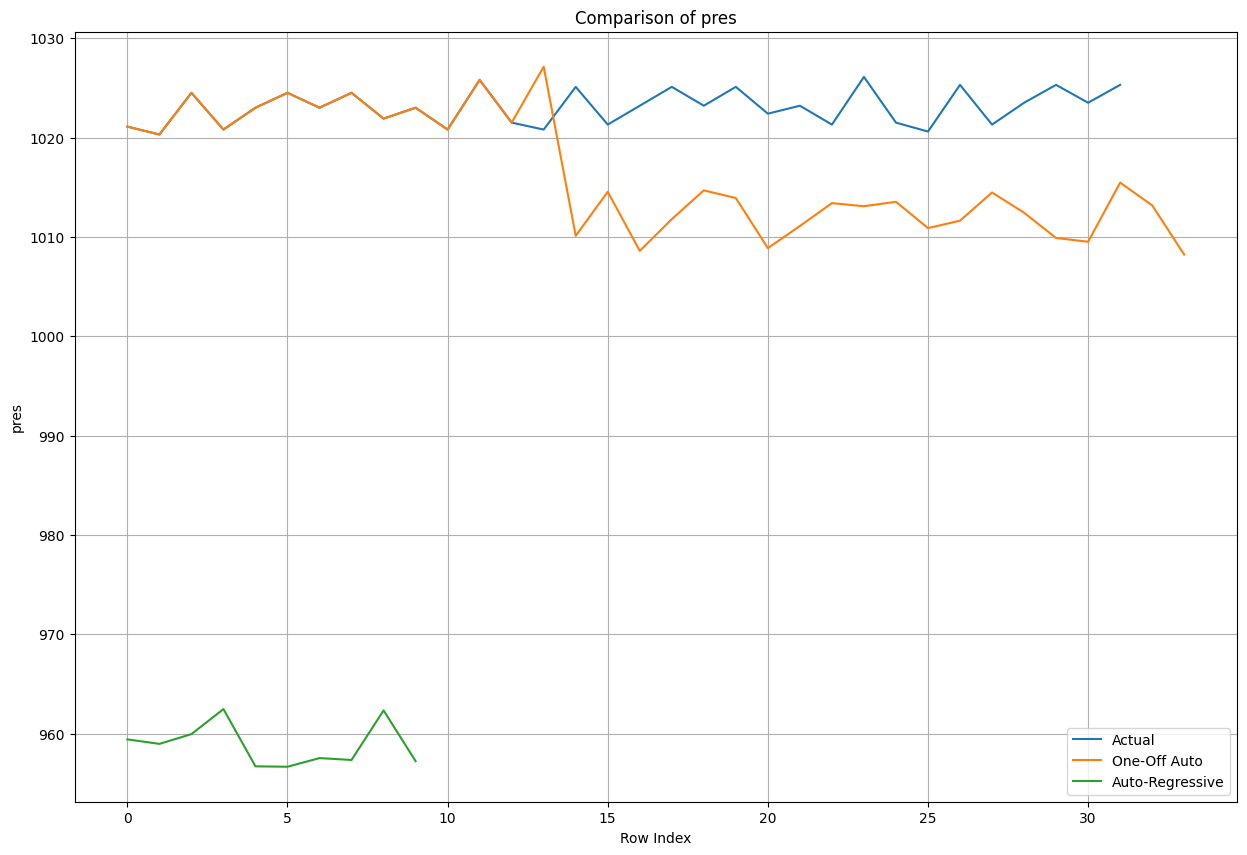

In [ ]:
plot_comparison(actual_df, auto_df, res_df, "pres")

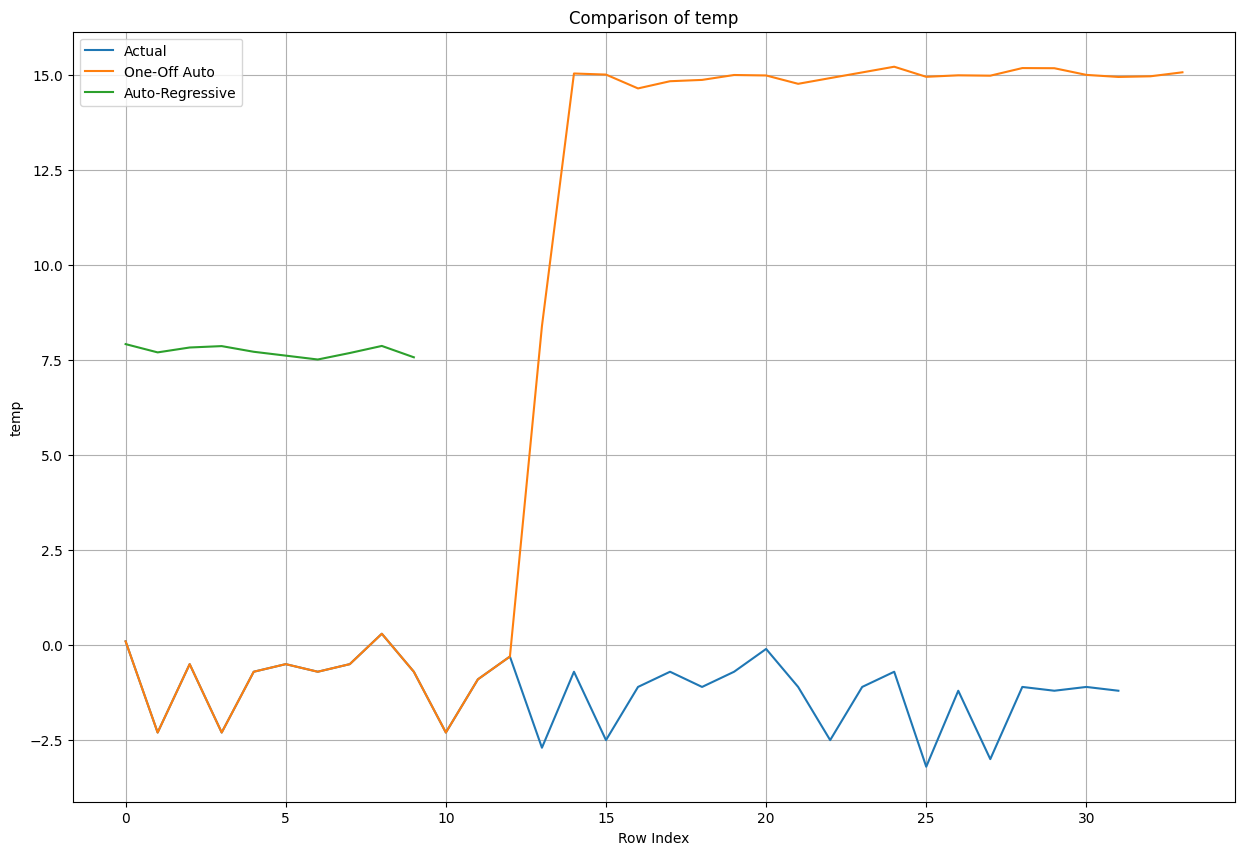

In [ ]:
plot_comparison(actual_df, auto_df, res_df, "temp")

In [ ]:
df.temp.mean()

np.float64(13.492384537594877)

In [ ]:
numeric_summary = df.select_dtypes(include=np.number).agg(["min", "max"])
print("Numeric columns min and max values:")
print(numeric_summary)

Numeric columns min and max values:
     year  month  day  hour  pm2_5   pm10       so2       no2       co  \
min  2013      1    1     0    2.0    2.0    0.2856    1.0265    100.0   
max  2017     12   31    23  999.0  999.0  500.0000  290.0000  10000.0   

            o3  temp    pres  dewp  rain  wspm    idx  
min     0.2142 -19.9   982.4 -43.4   0.0   0.0      0  
max  1071.0000  41.6  1042.8  29.1  72.5  13.2  12875  


In [ ]:
df.select_dtypes(include=np.number).columns

Index(['year', 'month', 'day', 'hour', 'pm2_5', 'pm10', 'so2', 'no2', 'co',
       'o3', 'temp', 'pres', 'dewp', 'rain', 'wspm', 'idx'],
      dtype='object')